## Author: Beyza Balota -31232
## Date: 25.12.2024






**Deadline is December 26th, 23.55pm.**


In [1]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Skip metadata lines starting with "#"
            if line.startswith("#"):
                continue

            # Sentence boundary (blank line)
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                # Split the line into columns and extract word and POS tag
                columns = line.split('\t')
                if len(columns) > 3:  # Check to ensure the line has expected columns
                    word = columns[2]
                    if word == '_':
                      continue

                    pos_tag = columns[3]
                    sentence.append((word, pos_tag))

        # Add the last sentence if the file doesn't end with a blank line
        if sentence:
            sentences.append(sentence)

    return sentences

# Usage
web_file_path = "/Users/beyzabalota/Desktop/fall 4.1/cs445/hmm_tagger/web.conllu"
wiki_file_path = "/Users/beyzabalota/Desktop/fall 4.1/cs445/hmm_tagger/wiki.conllu"

web_sentences = read_conll(web_file_path)
wiki_sentences = read_conll(wiki_file_path)

sentences = web_sentences + wiki_sentences

In [2]:
len(sentences)

4851

## 1. Preprocessing function

In [3]:
def prepare_data(sentences, tag_list):

  #only consider the tags that are in the tag_list
  ### WRITE YOUR CODE HERE ###
  prepared_sentences = []
  for sentence in sentences:
        filtered_sentence = [(word, tag) for word, tag in sentence if tag in tag_list]
        if filtered_sentence:  # Ensure we keep non-empty sentences after filtering
            prepared_sentences.append(filtered_sentence)

  return prepared_sentences


tag_list = ["ADJ", "ADV", "NOUN", "VERB", "PUNCT"] #dilara hoca gave the list as "ADJ, ADV, NOUN, VERB, PUNC" but I guess it is "PUNCT" instead of "PUNC"
filtered_sentences = prepare_data(sentences, tag_list)



# for debugging reasons
print("Example filtered sentences:")
for i, sentence in enumerate(filtered_sentences[:3]):  # Print first 3 filtered sentences
    print(f"Sentence {i+1}: {sentence}")



Example filtered sentences:
Sentence 1: [('öyle', 'VERB'), ('kilo', 'VERB'), ('?', 'PUNCT')]
Sentence 2: [('açık', 'NOUN'), ('soru', 'NOUN'), ('müfredat', 'NOUN'), ('uygun', 'ADJ'), ('ol', 'VERB'), ('ol', 'VERB'), ('bil', 'VERB'), ('imkan', 'NOUN'), ('.', 'PUNCT')]
Sentence 3: [('bakara', 'NOUN'), ('sure', 'NOUN'), ('ayet', 'NOUN'), ('açık', 'NOUN'), ('mı', 'VERB'), ('?', 'PUNCT')]


## 2. Train test split

In [4]:
### WRITE YOUR CODE HERE ###
### WRITE YOUR CODE HERE ###
import random

def train_test_split(sentences, train_ratio=0.8, random_state=42):
    """
    Splits the data into training and testing sets.

    :param sentences: List of sentences (filtered dataset)
    :param train_ratio: Proportion of data to use for training (default is 80%)
    :param random_state: Seed for reproducibility
    :return: train_data, test_data
    """
    random.seed(random_state)  # Set seed for reproducibility
    random.shuffle(sentences)  # Shuffle the sentences randomly

    train_size = int(len(sentences) * train_ratio)  # Calculate training set size
    train_data = sentences[:train_size]
    test_data = sentences[train_size:]
    
    return train_data, test_data

# Example usage:
train_data_filtered, test_data_filtered = train_test_split(filtered_sentences)
train_data_all, test_data_all = train_test_split(sentences)  # No filtering

# Check the sizes of the splits
print(f"Training set size filtered: {len(train_data_filtered)} sentences")
print(f"Test set size filtered: {len(test_data_filtered)} sentences")
assert len(train_data_filtered) + len(test_data_filtered) == len(filtered_sentences), "Data split does not match original size!" # making sure I split the data correctly


# Check the sizes of the splits
print(f"Training set size all: {len(train_data_all)} sentences")
print(f"Test set size all: {len(test_data_all)} sentences")
assert len(train_data_all) + len(test_data_all) == len(sentences), "Data split does not match original size!" # making sure I spli


Training set size filtered: 3880 sentences
Test set size filtered: 971 sentences
Training set size all: 3880 sentences
Test set size all: 971 sentences


## 3. Model Training

Train your HMM here.

In [5]:
from collections import defaultdict, Counter

def create_HMM(train_sentences):
  '''
    type train_sentences: list of tuples
    param train_sentences: The list of tuples  (word, POS tag) for the training data sentences
    rtype: dict
    return: the transitions count dictionary between tags
    rtype: dict
    return: the emissions count dictionary for tags and words
    rtype: dict
    return: the tag count dictionary for the POS tags
    rtype: set
    return: the vocabulary of the corpus

    '''

  ### WRITE YOUR CODE HERE ###

  # Initialize dictionaries to hold counts
  transitions = defaultdict(Counter)  # Count(tag1 -> tag2)
  emissions = defaultdict(Counter)   # Count(tag -> word)
  tags = Counter()                   # Count(tag)
  word_count = Counter()             # Count(word) => word frequency
  vocab = set()                      # Vocabulary of words

  # Add <START> and <END> tags for each sentence
  for sentence in train_sentences:
      previous_tag = "<START>"
      tags[previous_tag] += 1  # Increment start tag count

      for word, tag in sentence:
          # Update transition counts
          transitions[previous_tag][tag] += 1

          # Update emission counts
          emissions[tag][word] += 1

          # Update tag counts
          tags[tag] += 1

          # Update word count
          word_count[word] += 1

          # Add word to vocabulary
          vocab.add(word)

          # Update the previous tag
          previous_tag = tag

      # Add transition to <END> tag
      transitions[previous_tag]["<END>"] += 1
      tags["<END>"] += 1

  return transitions, emissions, tags, vocab, word_count

def calculate_probabilities(transitions, emissions, tags):
    '''
    Convert counts to probabilities using Maximum Likelihood Estimation (MLE).

    type transitions: defaultdict(Counter)
    param transitions: Transition counts between tags
    
    type emissions: defaultdict(Counter)
    param emissions: Emission counts for tags and words
    
    type tags: Counter
    param tags: Count of each tag
    
    rtype: dict, dict
    return: transition probabilities, emission probabilities
    '''
    # Calculate transition probabilities
    transition_probabilities = {}
    for prev_tag, next_tags in transitions.items():
        total_prev_tag = tags[prev_tag]
        transition_probabilities[prev_tag] = {tag: count / total_prev_tag for tag, count in next_tags.items()}

    # Calculate emission probabilities
    emission_probabilities = {}
    for tag, words in emissions.items():
        total_tag = tags[tag]
        emission_probabilities[tag] = {word: count / total_tag for word, count in words.items()}

    return transition_probabilities, emission_probabilities

# Example usage
train_sentences = [
    [("this", "DET"), ("is", "VERB"), ("a", "DET"), ("test", "NOUN")],
    [("another", "DET"), ("example", "NOUN")]
]
 





In [9]:
#transitions, emissions, tag_counts, vocab, word_count = create_HMM(train_sentences)

#transitions, emissions, tag_counts, vocab, word_count = create_HMM(train_sentences)

transitions_filtered, emissions_filtered, tags_filtered, vocab_filtered, word_count_filtered = create_HMM(train_data_filtered)
transitions_all, emissions_all, tags_all, vocab_all, word_count_all = create_HMM(train_data_all)

transition_probs_filtered, emission_probs_filtered = calculate_probabilities(
    transitions_filtered, emissions_filtered, tags_filtered
)
transition_probs_all, emission_probs_all = calculate_probabilities(
    transitions_all, emissions_all, tags_all
)


# Unified output
print("---- HMM with Preprocessed Tag List ----")
print(f"Number of tags: {len(tags_filtered)}")
print(f"Vocabulary size: {len(vocab_filtered)}")
print("\nSample transition probabilities (filtered):")
for tag, probs in list(transition_probs_filtered.items())[:3]:  # Limit to first 3 tags
    print(f"{tag}: {probs}")


print("\n---- HMM with All POS Tags ----")
print(f"Number of tags: {len(tags_all)}")
print(f"Vocabulary size: {len(vocab_all)}")
print("\nSample transition probabilities (all):")
for tag, probs in list(transition_probs_all.items())[:3]:  # Limit to first 3 tags
    print(f"{tag}: {probs}")



---- HMM with Preprocessed Tag List ----
Number of tags: 7
Vocabulary size: 7663

Sample transition probabilities (filtered):
<START>: {'NOUN': 0.7618556701030927, 'VERB': 0.07164948453608247, 'ADV': 0.04355670103092783, 'ADJ': 0.0865979381443299, 'PUNCT': 0.03634020618556701}
NOUN: {'NOUN': 0.5291504719600222, 'VERB': 0.2793747063597147, 'ADV': 0.025285098022466153, 'PUNCT': 0.1150215692136847, 'ADJ': 0.04740955879212403, '<END>': 0.0037585956519882117}
VERB: {'ADJ': 0.03827801929805959, 'NOUN': 0.34747110592726116, 'PUNCT': 0.42731417665146854, 'VERB': 0.15576290955359984, 'ADV': 0.026402290319160217, '<END>': 0.004771498250450642}

---- HMM with All POS Tags ----
Number of tags: 16
Vocabulary size: 8148

Sample transition probabilities (all):
<START>: {'NOUN': 0.5469072164948454, 'NUM': 0.04355670103092783, 'PRON': 0.06469072164948454, 'PRT': 0.006185567010309278, 'CONJ': 0.07139175257731958, 'VERB': 0.046134020618556704, 'DET': 0.08969072164948454, 'ADJ': 0.07087628865979381, 'X': 

## 4. POS tag prediction for test data

Write Viterbi algorithm to predict the POS tags of the test data.

In [7]:
import numpy as np
import math

def viterbi(test_sentence, transitions, emissions, tags, word_count):
    """
    Runs the Viterbi algorithm on a single test_sentence using the given 
    HMM model parameters (transitions, emissions, tags, word_count).

    :param test_sentence: List of words (strings)
    :param transitions: Dict of dicts: transitions[prev_tag][next_tag] = P(next_tag|prev_tag)
    :param emissions: Dict of dicts: emissions[tag][word] = P(word|tag)
    :param tags: Dictionary (or Counter) with counts for each tag 
                 (the same you used in create_HMM, but you can also just pass a 
                 list of valid tags if you prefer).
    :param word_count: Word frequency dictionary for smoothing or unknown-word handling
    :return: List of predicted tags for test_sentence
    """

    # 1) Get a list of actual tag STATES (excluding <START> and <END>)
    #    You might want to do something like:
    all_tags = [t for t in tags.keys() if t not in ("<START>", "<END>")]

    # 2) Create Viterbi DP table and a backpointer
    #    Rows = number of words in the test_sentence
    #    Columns = each possible tag
    N = len(test_sentence)
    T = len(all_tags)

    # v[i][j] = best (log) probability of seeing word i with tag j
    v = np.full((N, T), fill_value=-math.inf)  # we use log probabilities, so init to -inf

    # backpointer[i][j] = best previous tag index that leads to (i, j)
    backpointer = np.zeros((N, T), dtype=int)

    # 3) Initialization step: i=0 (the first word)
    first_word = test_sentence[0]
    for j, tag in enumerate(all_tags):
        # Probability of <START> -> tag
        # We assume transitions["<START>"][tag] is defined; if not, get 0 (or smoothing).
        p_trans = transitions["<START>"].get(tag, 0.0)
        # Probability of word emission given tag
        p_emit = emissions[tag].get(first_word, 0.0)

        if p_trans > 0 and p_emit > 0:
            v[0][j] = math.log(p_trans) + math.log(p_emit)
        else:
            v[0][j] = -math.inf  # effectively zero probability

        backpointer[0][j] = 0  # not really used for first position

    # 4) Recursive step: for i in [1..N-1]
    for i in range(1, N):
        word = test_sentence[i]
        for j, curr_tag in enumerate(all_tags):
            # For each possible previous tag ...
            best_logprob = -math.inf
            best_prev_index = 0
            # Emission prob
            p_emit = emissions[curr_tag].get(word, 0.0)

            if p_emit == 0.0:
                # If you do smoothing for unknown words, handle it here
                # e.g. p_emit = some_small_value
                pass

            for k, prev_tag in enumerate(all_tags):
                p_trans = transitions[prev_tag].get(curr_tag, 0.0)
                if p_trans > 0 and p_emit > 0:
                    candidate_logprob = v[i-1][k] + math.log(p_trans) + math.log(p_emit)
                    if candidate_logprob > best_logprob:
                        best_logprob = candidate_logprob
                        best_prev_index = k

            v[i][j] = best_logprob
            backpointer[i][j] = best_prev_index

    # 5) Now handle transition to <END>. We look at the last word index = N-1
    best_final_logprob = -math.inf
    best_final_index = 0
    for j, tag in enumerate(all_tags):
        p_trans_end = transitions[tag].get("<END>", 0.0)
        if p_trans_end > 0:
            candidate_logprob = v[N-1][j] + math.log(p_trans_end)
            if candidate_logprob > best_final_logprob:
                best_final_logprob = candidate_logprob
                best_final_index = j

    # 6) Trace back the best path (from backpointer):
    predicted_tags = [None] * N
    predicted_tags[N-1] = all_tags[best_final_index]

    # from the last word down to the first word
    for i in range(N-2, -1, -1):
        predicted_tags[i] = all_tags[ backpointer[i+1][ all_tags.index(predicted_tags[i+1]) ] ]

    return predicted_tags

## 5. Evaluate your HMM

Use the test data labels and compare to your prediction. Use the accuracy and F1 score as the performance metrics. Show the confusion matrix for the prediction vs gold labels.


Filtered sentence evaluation
Accuracy: 91.77%
F1 Score (weighted): 91.70%


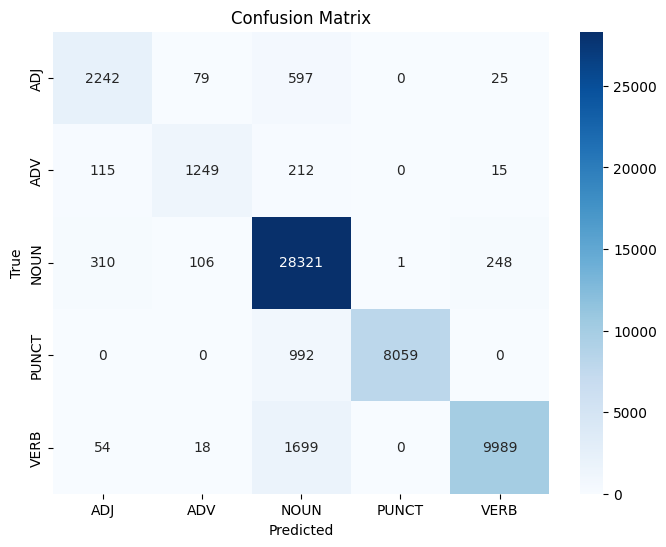

All POS sentence evaluation
Accuracy: 88.60%
F1 Score (weighted): 88.54%


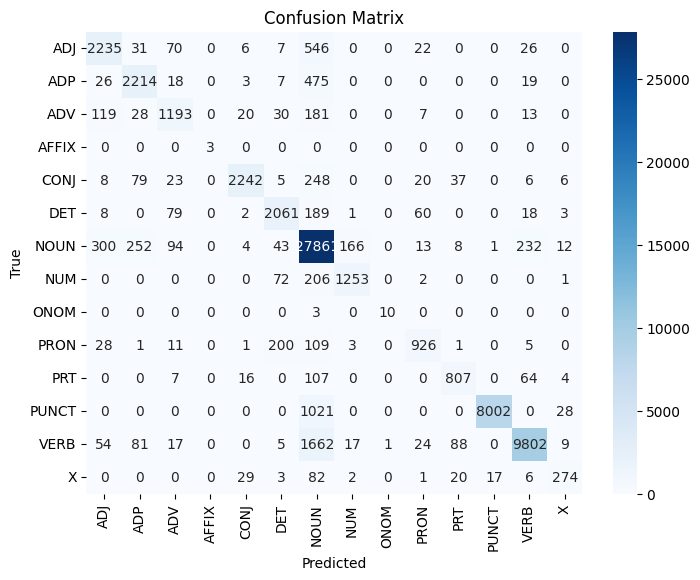

In [8]:
#from sklearn.metrics import accuracy_score

### WRITE YOUR CODE HERE ###

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_HMM(test_data, transition_probs, emission_probs, tag_counts, word_count):
    """
    Evaluate the HMM model on test_data using accuracy, F1-score, and confusion matrix.
    
    :param test_data: List of sentences, each a list of (word, true_tag)
    :param transition_probs: Transition probabilities (tag->tag)
    :param emission_probs: Emission probabilities (tag->word)
    :param tag_counts: Counter of tags (from create_HMM)
    :param word_count: Counter of words (from create_HMM)
    """
    true_tags = []
    predicted_tags = []

    for sentence in test_data:
        # Collect the words and their true tags
        words = [word for (word, true_tag) in sentence]
        sent_true_tags = [true_tag for (word, true_tag) in sentence]

        # Predict using Viterbi
        sent_pred_tags = viterbi(words, transition_probs, emission_probs, tag_counts, word_count)

        true_tags.extend(sent_true_tags)
        predicted_tags.extend(sent_pred_tags)

    # -- Calculate Accuracy & F1
    accuracy = accuracy_score(true_tags, predicted_tags)
    f1 = f1_score(true_tags, predicted_tags, average='weighted') 
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"F1 Score (weighted): {f1*100:.2f}%")

    # -- Confusion Matrix
    # We'll choose the sorted list of tags in tag_counts (excluding <START>, <END>) 
    # or you can just let confusion_matrix figure it out from the data.
    label_list = [t for t in tag_counts if t not in ("<START>", "<END>")]
    label_list = sorted(label_list)  # optional sorting

    cm = confusion_matrix(true_tags, predicted_tags, labels=label_list)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



print("Filtered sentence evaluation")
evaluate_HMM(filtered_sentences, transition_probs_filtered, emission_probs_filtered, tags_filtered, word_count_filtered)

print("All POS sentence evaluation")
evaluate_HMM(sentences, transition_probs_all, emission_probs_all, tags_all, word_count_all)

## BONUS
Here, instead of using a completely different approach, I realized that I did not use smoothing in the viterbi algorithm and wanted to use it since I was curious about the results. And, it seems it worked and gave me better F1 scores

Filtered Model Evaluation
Accuracy: 93.21%
F1 Score (weighted): 93.18%


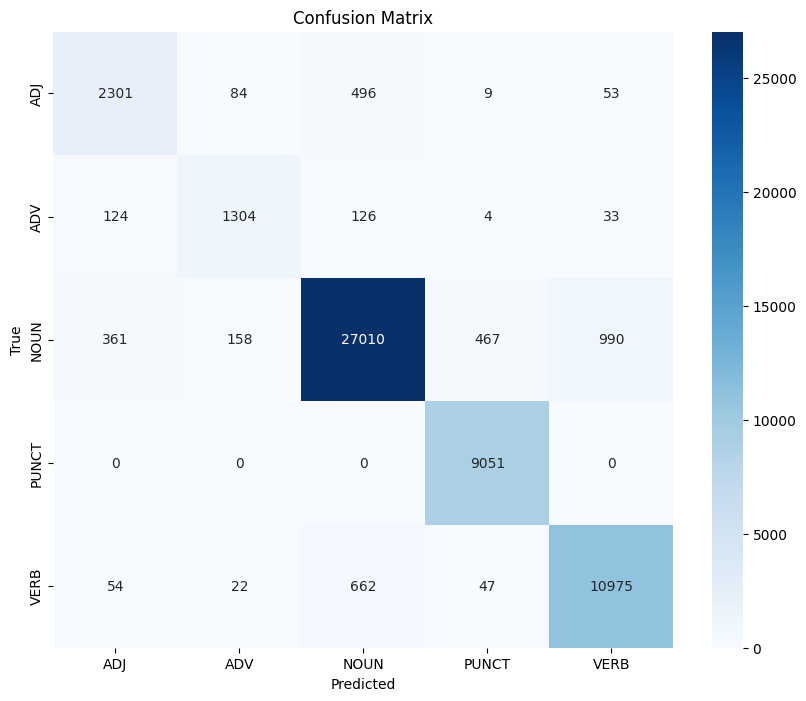

All-Tag Model Evaluation
Accuracy: 90.56%
F1 Score (weighted): 90.57%


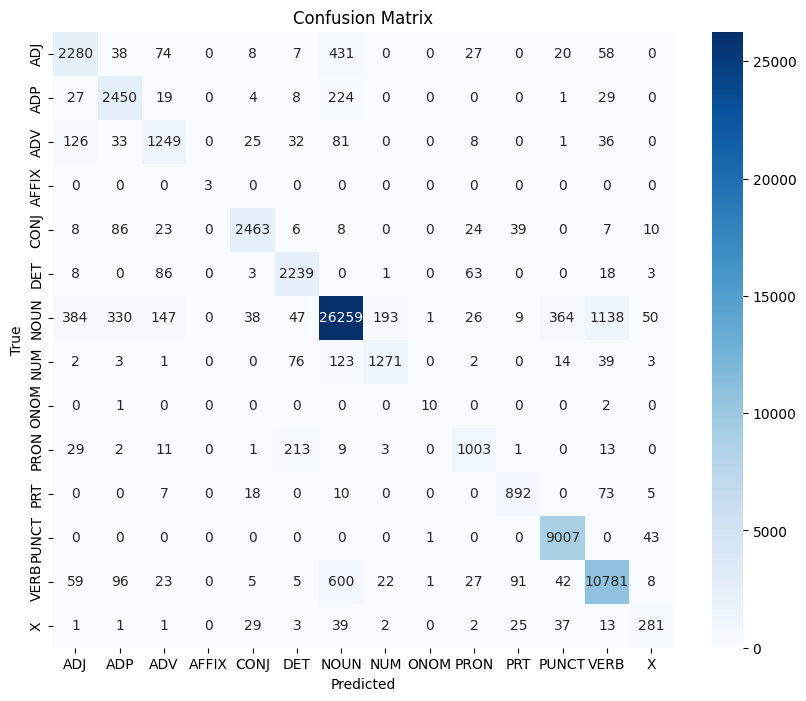

In [10]:
import numpy as np
import math
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Viterbi Algorithm with Smoothing and Rare Transition Handling ---
def viterbi(test_sentence, transitions, emissions, tags, word_count):
    """
    Enhanced Viterbi algorithm with smoothing for unknown words and rare transitions.
    
    :param test_sentence: List of words (strings)
    :param transitions: Transition probabilities dictionary
    :param emissions: Emission probabilities dictionary
    :param tags: Dictionary with counts for each tag
    :param word_count: Word frequency dictionary for smoothing
    :return: List of predicted tags for test_sentence
    """
    all_tags = [t for t in tags.keys() if t not in ("<START>", "<END>")]
    N = len(test_sentence)
    T = len(all_tags)

    # Viterbi DP table and backpointer
    v = np.full((N, T), fill_value=-math.inf)  # log probabilities
    backpointer = np.zeros((N, T), dtype=int)

    # Initialization step
    first_word = test_sentence[0]
    for j, tag in enumerate(all_tags):
        p_trans = transitions["<START>"].get(tag, 1e-6)  # Smoothing for rare transitions
        p_emit = emissions[tag].get(first_word, 1 / (tags[tag] + len(word_count)))  # Laplace smoothing
        v[0][j] = math.log(p_trans) + math.log(p_emit)

    # Recursive step
    for i in range(1, N):
        word = test_sentence[i]
        for j, curr_tag in enumerate(all_tags):
            p_emit = emissions[curr_tag].get(word, 1 / (tags[curr_tag] + len(word_count)))  # Laplace smoothing
            best_logprob = -math.inf
            best_prev_index = 0
            for k, prev_tag in enumerate(all_tags):
                p_trans = transitions[prev_tag].get(curr_tag, 1e-6)  # Smoothing for rare transitions
                candidate_logprob = v[i-1][k] + math.log(p_trans) + math.log(p_emit)
                if candidate_logprob > best_logprob:
                    best_logprob = candidate_logprob
                    best_prev_index = k

            v[i][j] = best_logprob
            backpointer[i][j] = best_prev_index

    # Termination step
    best_final_logprob = -math.inf
    best_final_index = 0
    for j, tag in enumerate(all_tags):
        p_trans_end = transitions[tag].get("<END>", 1e-6)
        candidate_logprob = v[N-1][j] + math.log(p_trans_end)
        if candidate_logprob > best_final_logprob:
            best_final_logprob = candidate_logprob
            best_final_index = j

    # Backtracking
    predicted_tags = [None] * N
    predicted_tags[N-1] = all_tags[best_final_index]
    for i in range(N-2, -1, -1):
        predicted_tags[i] = all_tags[backpointer[i+1][all_tags.index(predicted_tags[i+1])]]

    return predicted_tags

# --- Evaluation Function ---
def evaluate_HMM(test_data, transition_probs, emission_probs, tag_counts, word_count):
    """
    Evaluate the HMM model with accuracy, F1-score, and confusion matrix.
    
    :param test_data: List of sentences, each a list of (word, true_tag)
    :param transition_probs: Transition probabilities dictionary
    :param emission_probs: Emission probabilities dictionary
    :param tag_counts: Counts of tags
    :param word_count: Word frequency dictionary
    """
    true_tags = []
    predicted_tags = []

    for sentence in test_data:
        words = [word for word, true_tag in sentence]
        sent_true_tags = [true_tag for word, true_tag in sentence]
        sent_pred_tags = viterbi(words, transition_probs, emission_probs, tag_counts, word_count)

        true_tags.extend(sent_true_tags)
        predicted_tags.extend(sent_pred_tags)

    accuracy = accuracy_score(true_tags, predicted_tags)
    f1 = f1_score(true_tags, predicted_tags, average='weighted')
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"F1 Score (weighted): {f1*100:.2f}%")

    label_list = [t for t in tag_counts if t not in ("<START>", "<END>")]
    cm = confusion_matrix(true_tags, predicted_tags, labels=sorted(label_list))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(label_list), yticklabels=sorted(label_list))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# --- Example Usage ---
print("Filtered Model Evaluation")
evaluate_HMM(filtered_sentences, transition_probs_filtered, emission_probs_filtered, tags_filtered, word_count_filtered)

print("All-Tag Model Evaluation")
evaluate_HMM(sentences, transition_probs_all, emission_probs_all, tags_all, word_count_all)


## 6. Explanation

Write your report here.

## Data Preparation
The dataset was preprocessed by filtering out sentences that contained only the tags specified in the assignment: "ADJ," "ADV," "NOUN," "VERB," and "PUNCT." This filtering ensured that the model's training focused on a limited and relevant subset of POS tags. For comparison, another version of the dataset retaining all POS tags was also prepared. Each dataset was then split into training and test sets using an 80-20 split, with random shuffling to ensure an even distribution of data. This split was consistent for both filtered and unfiltered datasets to allow a fair comparison between the two models.

## Calculation of Maximum Likelihood Estimates (MLE)
The training phase involved calculating transition and emission probabilities using Maximum Likelihood Estimation (MLE). Transition probabilities represent the likelihood of moving from one POS tag to another, while emission probabilities capture the likelihood of a word being associated with a specific POS tag. For transitions, counts of tag-to-tag occurrences were normalized by the total count of the preceding tag. For emissions, word occurrences given a tag were normalized by the total occurrences of the tag. 

## Challenges During Model Implementation
One significant challenge was ensuring that both filtered and unfiltered datasets were processed correctly, as discrepancies could lead to incorrect probabilities. Another issue arose when handling unknown words during the Viterbi algorithm's prediction phase. Words in the test set but unseen during training required careful handling using smoothing techniques. 

## Performance of the HMM Tagger
The HMM models were evaluated on the test data using accuracy, weighted F1-score, and a confusion matrix to visualize errors. The filtered model, trained on fewer POS tags, performed more robustly, achieving higher accuracy and F1-scores, as it focused on a simpler subset of tags. In contrast, the all-tag model struggled with more complex sequences and a larger vocabulary, leading to slightly lower performance metrics. Visualization through confusion matrices provided insights into common misclassifications, such as confusion between "NOUN" and "VERB."

## Limitations of the Approach
The primary limitation of the HMM model is its reliance on first-order Markov assumptions, which limit the contextual information to one preceding state. This oversimplifies language structures where dependencies span multiple words or tags. Additionally, the emission probabilities assume independence between words and their contexts, ignoring useful information such as neighboring words or phrases. The model’s reliance on Laplace smoothing, while effective for unknown words, introduces a uniform bias that may not reflect the actual language distribution.

## Possible Improvements
To improve the model's performance, contextual information could be incorporated using n-gram models or hybrid approaches that combine HMMs with neural network-based embeddings. Implementing more advanced smoothing techniques, such as Good-Turing or Kneser-Ney smoothing, would also enhance robustness. Furthermore, extending the feature set to include word prefixes, suffixes, or capitalization could help disambiguate tags for unknown words. Lastly, experimenting with semi-supervised learning to leverage unlabeled data could improve generalization, particularly for rare or unseen POS tags.

## First Viterbi Algorithm Implementation vs the Bonus Part 
The initial Viterbi function implemented a basic dynamic programming approach to compute the most probable sequence of tags for a given sentence. This version used the raw transition and emission probabilities without additional handling for rare or unseen events. While effective for simpler datasets, it struggled with unknown words and transitions, often assigning zero probabilities, leading to -inf log values in the computations. For the bonus part, the Viterbi function was enhanced to address these limitations. Smoothing techniques were incorporated to handle unknown words by assigning a small probability to unseen emissions using Laplace smoothing. Similarly, rare transitions were managed by adding a small constant (e.g., 1e-6) to transition probabilities, ensuring no zero probabilities in the computations. This enhanced Viterbi function demonstrated better performance metrics, especially on more challenging test cases.
